In [ ]:
from pathlib import Path
from typing import Optional
from typing import Optional, Union
import numpy as np
import torch
from torch import Tensor
from pytorch_metric_learning import distances
from torch.utils.data import TensorDataset, WeightedRandomSampler
from torch.utils.data.dataloader import DataLoader

from src.bo_vae_sdr.vae.data_generator import DatasetPrepare
from src.bo_vae_sdr.vae.model import LSBOVAE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

In [ ]:
feature_dim = 5
latent_dim = 2
hparams = {
    "beta_start": None,
    "beta_final": 1.,
    "beta_step": 1.1,
    "beta_step_freq": 5,
    "beta_warmup": 50,
    "beta_metric_loss": 1,
    "metric_loss": {
        "type": "triplet",
        "threshold": 0.1,
        "margin": None,
        "soft": True,
        "eta": 0.01,
    },
    # data generator params
    "num_sample": 2000,
    "feature_dim": feature_dim,
    "target_dim": 1,
    "data_split": 0.9,
    "sampling_method": "normal",
    "batch_size": 128,
    "obj_func_kw": "ackley",# it does not matter
    # weight
    "weight_type": "uniform",
    # vae encoder
    "latent_dim": latent_dim,
    "encoder_layer_dims": [feature_dim, 3, latent_dim],
    "decoder_layer_dims": [latent_dim, 3, feature_dim],
}
opt_params = {"lr": 1e-3}
model = LSBOVAE(hparams=hparams).to(device=device)
model.load_state_dict(torch.load('./output/000_pre_trained_vae/model.pth'))


<All keys matched successfully>

In [ ]:
_, test_loader = DatasetPrepare(hparams=hparams).load(
            train_path=Path('./output/000_pre_trained_vae/train_set.pth'), test_path=Path('./output/000_pre_trained_vae/test_set.pth')
        )

dataset load
torch.Size([1800, 5])
torch.Size([1800, 1])
torch.Size([200, 5])
torch.Size([200, 1])


In [4]:
zs = []
ys = []
for test_x, y in test_loader:
            mu, logvar = model.encoder(test_x.to(device))
            z = model.sample_latent(mu=mu, logvar=logvar)
            zs.append(z)
            ys.append(y)

In [5]:
class TripletLossTorch:
    def __init__(self, threshold: float, margin: Optional[float] = None, soft: Optional[bool] = False,
                 eta: Optional[float] = None):
        """
        Compute Triplet loss
        Args:
            threshold: separate positive and negative elements in temrs of `y` distance
            margin: hard triplet loss parameter
            soft: whether to use sigmoid version of triplet loss
            eta: parameter of hyperbolic function softening transition between positive and negative classes
        """
        self.threshold = threshold
        self.margin = margin
        self.soft = soft
        assert eta is None or eta > 0, eta
        self.eta = eta

    def build_loss_matrix(self, embs: Tensor, ys: Tensor):
        neg_emb = torch.linspace(0, 2, 100, device=device)
        neg_ys = torch.linspace(0, 1, 100, device=device)
        # neg_emb_mesh, neg_ys_mesh = torch.meshgrid(neg_emb, neg_ys)
        loss = torch.zeros((100,100), device=device)
        
        for i in range(100):
            for j in range(100):

                pos_i = torch.tensor([0.6], device=device)
            
                neg_i = neg_emb[i]
            
                if self.soft:
                    triplet_losses_for_anchor_i = torch.nn.functional.softplus(pos_i - neg_i)
                    if self.eta is not None:
                        # get the corresponding delta ys
                        pos_y_i = torch.tensor([0.1], device=device)
                        neg_y_i = neg_ys[j]
                        
                        # triplet_losses_for_anchor_i = (triplet_losses_for_anchor_i * \
                        #                             self.smooth_indicator(self.threshold - pos_y_i) \
                        #                                 .div(self.smooth_indicator(self.threshold)) \
                        #                             * self.smooth_indicator(neg_y_i - self.threshold) \
                        #                                 .div(self.smooth_indicator(1 - self.threshold)) )*self.identity_indicator(pos_y_i, neg_y_i)
                        triplet_losses_for_anchor_i = (triplet_losses_for_anchor_i)*self.identity_indicator(pos_y_i, neg_y_i)
                        
                        loss[i,j] = triplet_losses_for_anchor_i
                    
                else:
                    triplet_losses_for_anchor_i = torch.relu(self.margin + pos_i - neg_i)
                    loss[i,j] = triplet_losses_for_anchor_i
            
        return loss.cpu().detach().numpy()

    def identity_indicator(self, yp, yn):
        if yp < self.threshold and yn >= self.threshold:
            return 1
        else:
            return 0 
    def smooth_indicator(self, x: Union[Tensor, float]) -> Union[Tensor, float]:
        if isinstance(x, float):
            return np.tanh(x / (2 * self.eta))
        return torch.tanh(x / (2 * self.eta))

    def compute_loss(self, embs: Tensor, ys: Tensor):
        return self.build_loss_matrix(embs, ys)

    def __call__(self, embs: Tensor, ys: Tensor):
        return self.compute_loss(embs, ys)

In [6]:
TL = TripletLossTorch(threshold=0.25, margin=0.25, soft=True, eta=0.05)
loss = TL.build_loss_matrix(embs=zs, ys=ys)
# print(loss)

Text(0.5, 1.0, 'Triplet Loss $(\\eta = 0.25)$ - With no smoothening ($\\nu \\rightarrow 0$)')

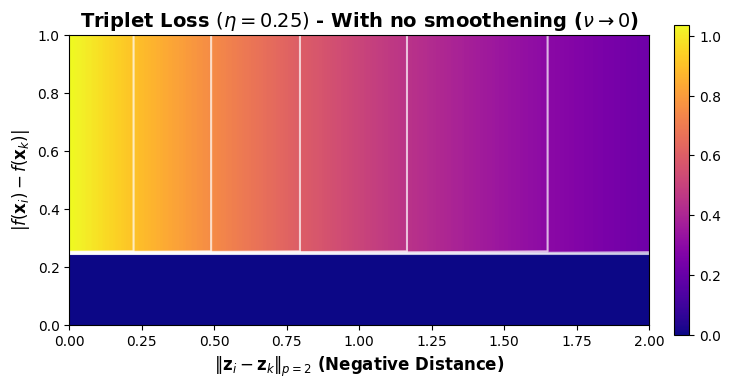

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,6))
im = ax.imshow(loss.T,origin='lower', cmap = 'plasma', extent=[0, 2, 0, 1])
ax.contour(loss.T, extent=[0, 2, 0, 1], colors = 'white', alpha = 0.7)
cbar = fig.colorbar(im, ax = ax,fraction=0.025, pad=0.04)
ax.set_xlabel(r'$\|\mathbf{z}_i - \mathbf{z}_k\|_{p = 2}$ (Negative Distance)', fontsize=12, weight='bold')
ax.set_ylabel(r'$|f(\mathbf{x}_i) - f(\mathbf{x}_k)|$', fontsize=12, weight='bold')
ax.set_title(r'Triplet Loss $(\eta = 0.25)$ - With no smoothening ($\nu \rightarrow 0$)', fontsize=14, weight='bold')
# plt.axis()
